# Title

## Introduction

In [1]:
'''
All the imports for the project
'''

# Basic imports 
import json     # parse json objects
import re       # text clean up

# Data processing
import pandas as pd
import numpy as np

# Embeddings
import torch
from sentence_transformers import SentenceTransformer       # text -> vector embeddings

# Clustering
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer     # find keywords

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
path = "Electronics.jsonl"
reviews = []
max_rows = 1000000       # take first 1m reviews

# Open jsonl file and add each line (review) to reviews list
with open(path, "r") as f:
    for i, line in enumerate(f):
        if i >= max_rows:
            break
        reviews.append(json.loads(line))

# Convert to DF
df = pd.DataFrame(reviews)

# Display info
df.shape, df.info(), df[["rating", "title", "text"]].head(10)
df["rating"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   rating             1000000 non-null  float64
 1   title              1000000 non-null  object 
 2   text               1000000 non-null  object 
 3   images             1000000 non-null  object 
 4   asin               1000000 non-null  object 
 5   parent_asin        1000000 non-null  object 
 6   user_id            1000000 non-null  object 
 7   timestamp          1000000 non-null  int64  
 8   helpful_vote       1000000 non-null  int64  
 9   verified_purchase  1000000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 69.6+ MB


rating
5.0    649913
4.0    141739
1.0     89031
3.0     71612
2.0     47705
Name: count, dtype: int64

In [3]:
# Choose same number of reviews per rating
groups = df.groupby("rating")
balanced = []

for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    group = groups.get_group(rating)
    balanced.append(group.sample(20000, random_state=42)) # Take 20k reviews from each rating

balanced_df = pd.concat(balanced).reset_index(drop=True)

balanced_df["rating"].value_counts()

rating
1.0    20000
2.0    20000
3.0    20000
4.0    20000
5.0    20000
Name: count, dtype: int64

In [4]:
#shows the top 10 rows of the dataset
balanced_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Looks like something you get at the dollar store,Cheap looking. Looks like something you get a...,[],B01AG1GYLG,B09Y52BZC8,AFWIMAWDZVZIZPI4RT22S4N44OKQ,1492230370000,0,True
1,1.0,didn't really work,"I would look for another product, to provide y...",[],B014YN7LVE,B014YN7LVE,AF2II3AEAIAWPYLIL3EGSLGZXHRQ,1633074481836,0,True
2,1.0,Lids,Lids are very loose,[],B08JC55TTL,B0C3CGLWMW,AHWQFYQLHX4QEQETNKBXYOKUOM7A,1663977271449,1,True
3,1.0,"Good idea, defective screen...",Do not buy this. After a couple of months of u...,[],B00N7MFZGM,B00N7MFZGM,AHE2BITVBXIVESDN3A6YRHYT7R6Q,1463584075000,0,False
4,1.0,Broke out of the box,I'm a big TomTom fan and recommend them to man...,[],B003B3P2CY,B003B3P2CY,AHWRXLKSLGKDWKHTMUI2LHXJLOWA,1294088291000,2,True


In [5]:
# Process data

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()                         # lower case
    text = re.sub(r"[^a-z0-9\s]", " ", text)    # keep letters, numbers, and spaces
    text = re.sub(r'\bbr\b', ' ', text)         # removes "br" (interferes with data processing)
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text

# Create new column with cleaned text
balanced_df["cleaned_text"] = balanced_df["text"].apply(clean_text)

# Remove faulty text after cleaning
balanced_df = balanced_df[balanced_df["cleaned_text"].str.len() > 0].reset_index(drop=True)

#the text before and after cleaning
balanced_df[["text", "cleaned_text"]].head(10)

,text,cleaned_text
0,Cheap looking. Looks like something you get a...,cheap looking looks like something you get at ...
1,"I would look for another product, to provide y...",i would look for another product to provide yo...
2,Lids are very loose,lids are very loose
3,Do not buy this. After a couple of months of u...,do not buy this after a couple of months of us...
4,I'm a big TomTom fan and recommend them to man...,i m a big tomtom fan and recommend them to man...
5,didnt work,didnt work
6,"This unit sucks, had to return it cause you ca...",this unit sucks had to return it cause you can...
7,It has one function and doesn't perform that f...,it has one function and doesn t perform that f...
8,Garbage has static feedback,garbage has static feedback
9,"These Panasonic earbuds work fairly well, but ...",these panasonic earbuds work fairly well but d...


In [6]:
# Create vector embeddings from cleaned text

# Use pretrained light model
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

texts = balanced_df["cleaned_text"].tolist()
embeddings = model.encode(texts, batch_size=64, device=device, show_progress_bar=True)

Batches:   0%|          | 0/1562 [00:00<?, ?it/s]

In [7]:
# Cluster using k means

# Expected 3 groups: positive, neutral, and negative
k = 3

# Run k means and store labels
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(embeddings)
balanced_df["cluster"] = kmeans_labels
balanced_df[["rating", "cleaned_text", "cluster"]].head(10)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,rating,cleaned_text,cluster
0,1.0,cheap looking looks like something you get at ...,1
1,1.0,i would look for another product to provide yo...,1
2,1.0,lids are very loose,2
3,1.0,do not buy this after a couple of months of us...,0
4,1.0,i m a big tomtom fan and recommend them to man...,0
5,1.0,didnt work,0
6,1.0,this unit sucks had to return it cause you can...,0
7,1.0,it has one function and doesn t perform that f...,0
8,1.0,garbage has static feedback,0
9,1.0,these panasonic earbuds work fairly well but d...,2


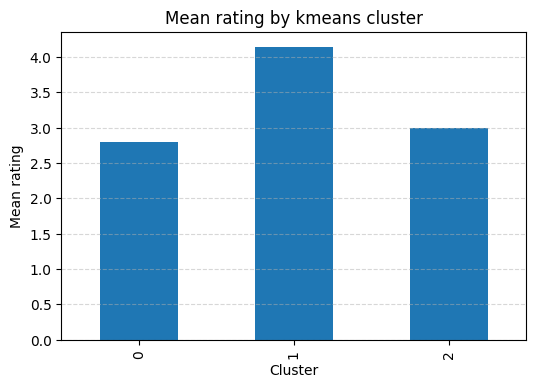

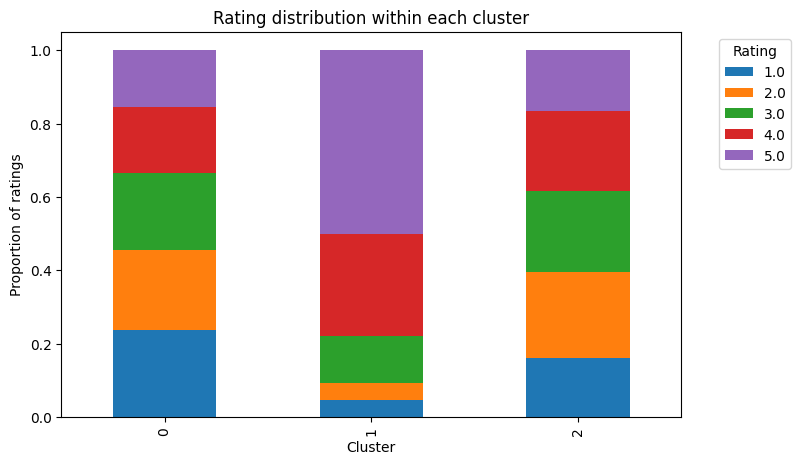

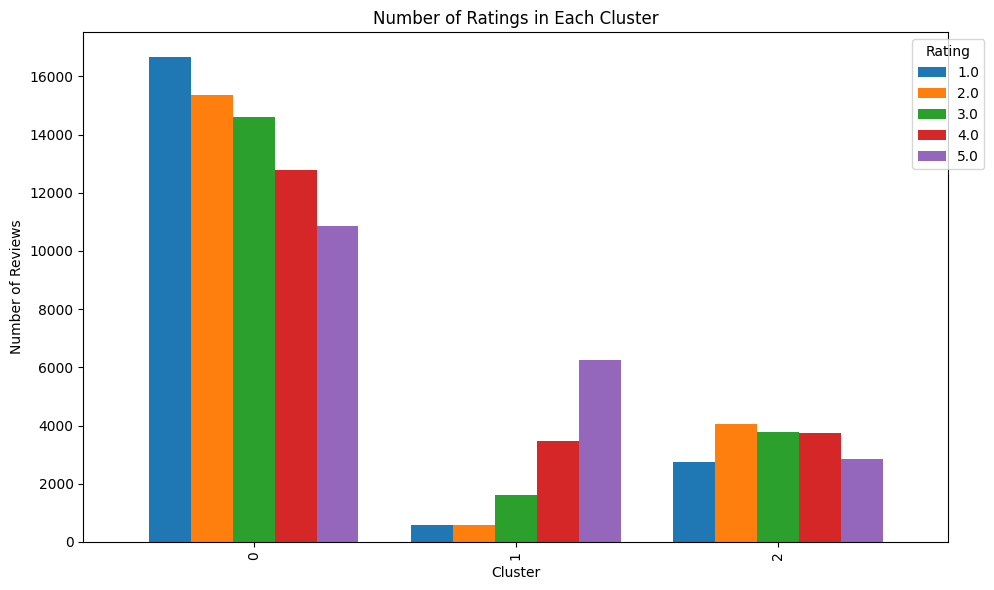

In [8]:
# Visualize k means - weihao's version

cluster_means = balanced_df.groupby("cluster")["rating"].mean()

plt.figure(figsize=(6,4))
cluster_means.plot(kind="bar")
plt.ylabel("Mean rating")
plt.xlabel("Cluster")
plt.title("Mean rating by kmeans cluster")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


rating_dist = pd.crosstab(balanced_df["cluster"], balanced_df["rating"], normalize="index")

rating_dist.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Proportion of ratings")
plt.xlabel("Cluster")
plt.title("Rating distribution within each cluster")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

count_table = pd.crosstab(balanced_df["cluster"], balanced_df["rating"])

count_table.plot(kind="bar", figsize=(10,6), width=0.8)

plt.title("Number of Ratings in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [9]:
# TFIDF to find keywords

# Fit vectorizer 
tfidf = TfidfVectorizer(max_features=5000, min_df=5, stop_words = 'english') # review x word matrix where entries are tfidf (importance) scores
X = tfidf.fit_transform(texts)
vocab = np.array(tfidf.get_feature_names_out())

# Find top n keywords per cluster
top_n = 10
for cluster in sorted(balanced_df["cluster"].unique()):
    mask = balanced_df["cluster"] == cluster # vector identifying which reviews are in cluster
    X_cluster = X[mask.to_numpy()] # only include reviews in cluster
    
    # Calculate average tfidf score per word in cluster and sort descending
    mean_tfidf = X_cluster.mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    top_words = vocab[top_idx]

    # Display
    print(f"\nCluster {cluster} top words:")
    print(", ".join(top_words))


Cluster 0 top words:
work, use, just, like, great, works, case, good, camera, does

Cluster 1 top words:
great, good, works, product, love, ok, price, quality, nice, perfect

Cluster 2 top words:
sound, headphones, good, quality, ear, great, speaker, music, speakers, use


**Prisca's version**

1) filtered out balanced_df for negative product ratings = (ratings must be below 2.0)

In [10]:
#taking only the negative product reviews and creating a new dataset  
df_neg = balanced_df[balanced_df["rating"] <= 2]
embeddings_neg = embeddings[balanced_df["rating"] <= 2]

In [11]:
#clustering using k means 
k = 5

#run kmeans and store labels
kmeans_neg = KMeans(n_clusters=k, random_state = 42, n_init="auto")
kmeans_neg_labels = kmeans_neg.fit_predict(embeddings_neg)
df_neg["cluster"] = kmeans_neg_labels
df_neg[["rating", "cleaned_text", "cluster"]].head()

/var/folders/zl/rkhnr4jj3m562vr5p3lz0jb40000gn/T/ipykernel_96848/3707309106.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg["cluster"] = kmeans_neg_labels


,rating,cleaned_text,cluster
0,1.0,cheap looking looks like something you get at ...,4
1,1.0,i would look for another product to provide yo...,2
2,1.0,lids are very loose,4
3,1.0,do not buy this after a couple of months of us...,2
4,1.0,i m a big tomtom fan and recommend them to man...,2


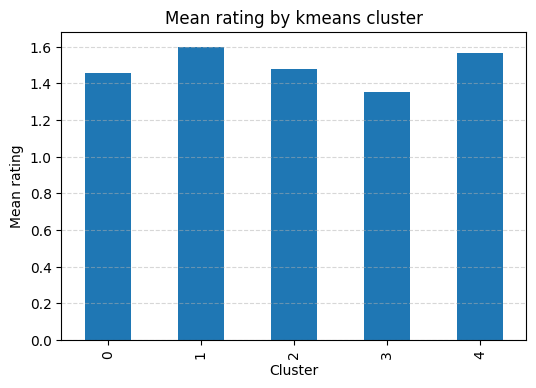

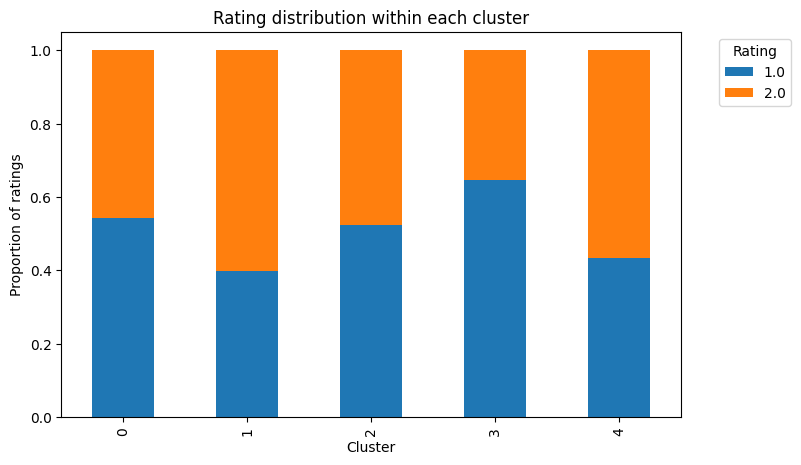

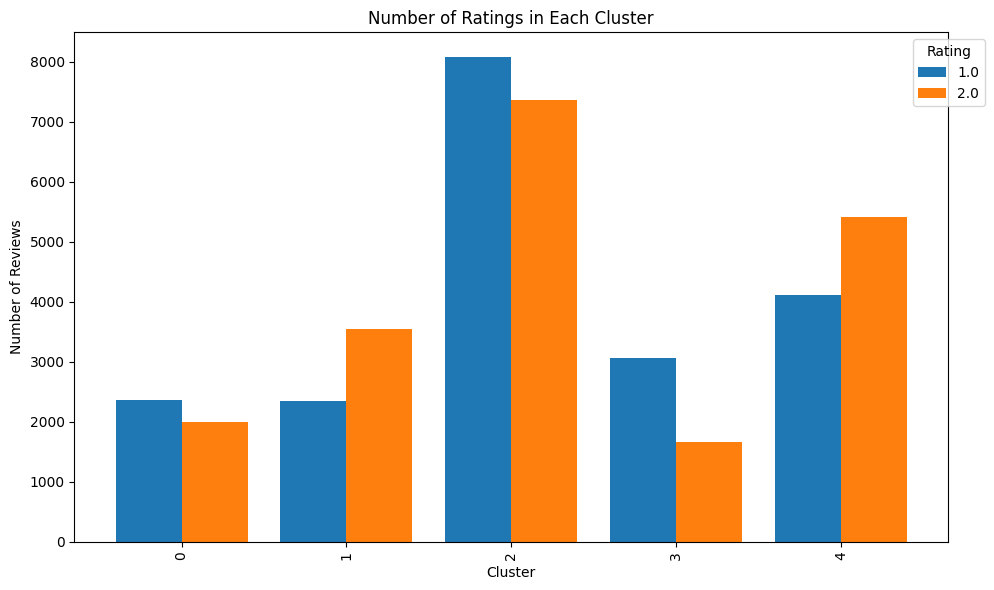

In [12]:
cluster_neg_means = df_neg.groupby("cluster")["rating"].mean()

plt.figure(figsize=(6,4))
cluster_neg_means.plot(kind="bar")
plt.ylabel("Mean rating")
plt.xlabel("Cluster")
plt.title("Mean rating by kmeans cluster")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

rating_dist_neg = pd.crosstab(df_neg["cluster"], df_neg["rating"], normalize="index")

rating_dist_neg.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Proportion of ratings")
plt.xlabel("Cluster")
plt.title("Rating distribution within each cluster")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

neg_count_table = pd.crosstab(df_neg["cluster"], df_neg["rating"])

neg_count_table.plot(kind="bar", figsize=(10,6), width=0.8)

plt.title("Number of Ratings in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [13]:
# TFIDF to find keywords

# Fit vectorizer 
tfidf = TfidfVectorizer(max_features=5000, min_df=5, stop_words = 'english') # review x word matrix where entries are tfidf (importance) scores
X = tfidf.fit_transform(df_neg["cleaned_text"])
vocab = np.array(tfidf.get_feature_names_out())

# Find top n keywords per cluster
top_n = 15
for cluster in sorted(df_neg["cluster"].unique()):
    mask = df_neg["cluster"] == cluster # vector identifying which reviews are in cluster
    X_cluster = X[mask.to_numpy()] # only include reviews in cluster
    
    # Calculate average tfidf score per word in cluster and sort descending
    mean_tfidf = X_cluster.mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    top_words = vocab[top_idx]

    # Display
    print(f"\nCluster {cluster} top words:")
    print(", ".join(top_words))


Cluster 0 top words:
charge, battery, charging, charger, cable, cord, batteries, work, phone, power, months, usb, cables, use, just

Cluster 1 top words:
sound, ear, headphones, quality, good, ears, speaker, speakers, music, work, volume, great, bluetooth, just, earbuds

Cluster 2 top words:
work, just, use, time, tv, camera, amazon, product, does, did, like, screen, bought, device, don

Cluster 3 top words:
work, didn, returned, did, working, broke, money, worked, stopped, months, waste, good, return, don, product

Cluster 4 top words:
case, fit, product, ipad, cheap, like, use, just, cover, don, plastic, does, work, doesn, buy


what each cluster seems to talk about: 
* Cluster 0: battery and charging related reviews 
* cluster 1: sound and auditory related eletronics 
* cluster 2: neutral 
* cluster 3: the functionality of the product
* cluster 4: neutral ish 

2. attempting to cluster balanced_df into 5 clusters

In [14]:
# Cluster using k means

#attempting 5 groups 
k = 5

# Run k means and store labels
kmeans_2 = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_2_labels = kmeans_2.fit_predict(embeddings)
balanced_df["cluster_2"] = kmeans_2_labels
balanced_df[["rating", "cleaned_text", "cluster_2"]].head(10)

,rating,cleaned_text,cluster_2
0,1.0,cheap looking looks like something you get at ...,0
1,1.0,i would look for another product to provide yo...,4
2,1.0,lids are very loose,0
3,1.0,do not buy this after a couple of months of us...,4
4,1.0,i m a big tomtom fan and recommend them to man...,4
5,1.0,didnt work,1
6,1.0,this unit sucks had to return it cause you can...,4
7,1.0,it has one function and doesn t perform that f...,1
8,1.0,garbage has static feedback,4
9,1.0,these panasonic earbuds work fairly well but d...,2


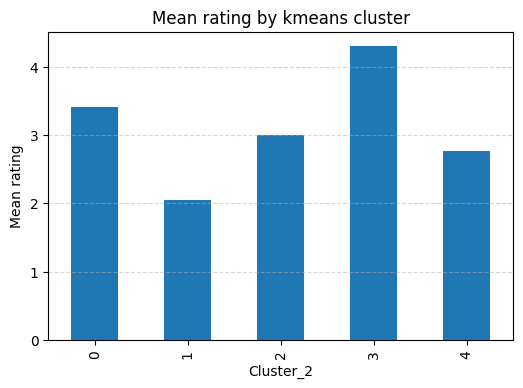

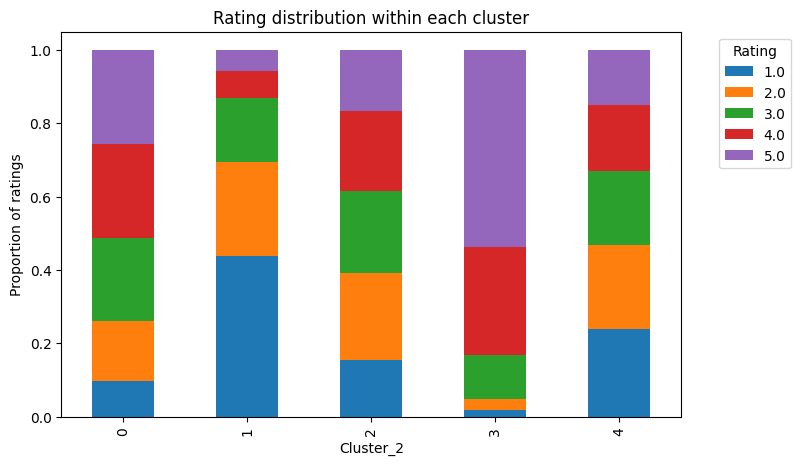

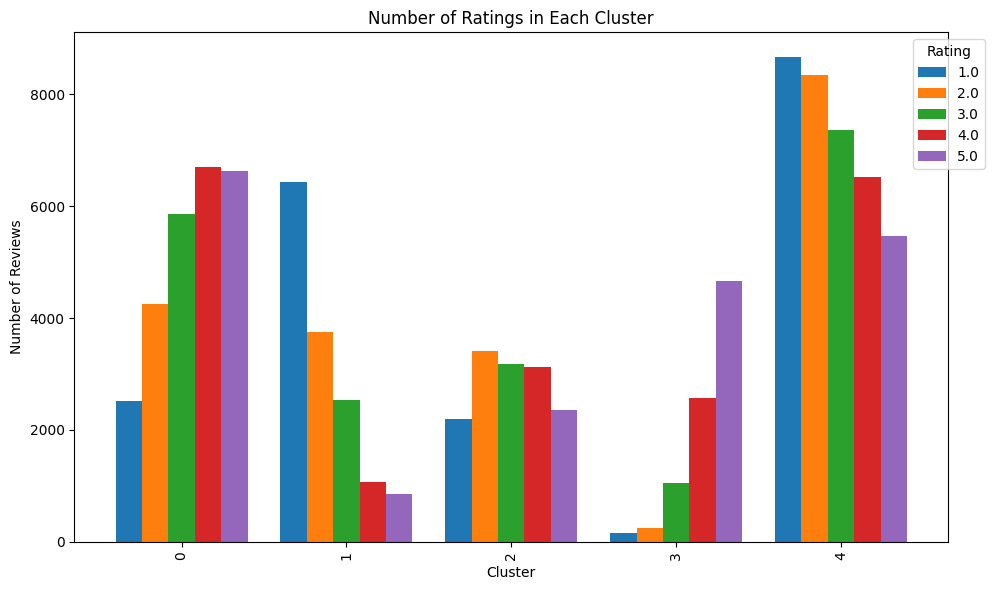

In [15]:
cluster_2_means = balanced_df.groupby("cluster_2")["rating"].mean()

plt.figure(figsize=(6,4))
cluster_2_means.plot(kind="bar")
plt.ylabel("Mean rating")
plt.xlabel("Cluster_2")
plt.title("Mean rating by kmeans cluster")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

rating_dist_2 = pd.crosstab(balanced_df["cluster_2"], balanced_df["rating"], normalize="index")

rating_dist_2.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Proportion of ratings")
plt.xlabel("Cluster_2")
plt.title("Rating distribution within each cluster")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

count_table_2 = pd.crosstab(balanced_df["cluster_2"], balanced_df["rating"])

count_table_2.plot(kind="bar", figsize=(10,6), width=0.8)

plt.title("Number of Ratings in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

* cluster 0: evenly split
* cluster 1: predominantly 1.0 reviews 
* cluster 2: evenly split
* cluster 3: predominantly 5.0 reviews
* cluster 4: evenly split

In [16]:
# TFIDF to find keywords

# Fit vectorizer 
tfidf_2 = TfidfVectorizer(max_features=5000, min_df=5, stop_words = 'english') # review x word matrix where entries are tfidf (importance) scores
X = tfidf_2.fit_transform(texts)
vocab = np.array(tfidf_2.get_feature_names_out())

# Find top n keywords per cluster
top_n = 10
for cluster in sorted(balanced_df["cluster_2"].unique()):
    mask = balanced_df["cluster_2"] == cluster # vector identifying which reviews are in cluster
    X_cluster = X[mask.to_numpy()] # only include reviews in cluster
    
    # Calculate average tfidf score per word in cluster and sort descending
    mean_tfidf_2 = X_cluster.mean(axis=0)
    mean_tfidf_2 = np.asarray(mean_tfidf_2).ravel()
    top_idx = mean_tfidf_2.argsort()[::-1][:top_n]
    top_words = vocab[top_idx]

    # Display
    print(f"\nCluster {cluster} top words:")
    print(", ".join(top_words))


Cluster 0 top words:
case, great, like, good, use, ipad, works, fit, just, camera

Cluster 1 top words:
work, didn, did, returned, months, broke, working, worked, return, money

Cluster 2 top words:
sound, headphones, quality, ear, good, great, speaker, speakers, music, ears

Cluster 3 top words:
great, good, works, product, ok, love, price, quality, perfect, nice

Cluster 4 top words:
work, use, cable, just, works, tv, time, great, battery, like


* cluster 1 (more 1.0): faulty products, customer consider returning product
* cluster 3 (more 5.0): high usage of positive adjectives - great, good, love, perfect, nice 

3. attempting to cluster balanced_df into 6 clusters

In [17]:
# Cluster using k means

#attempting 6 groups 
k = 6

# Run k means and store labels
kmeans_3 = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_3_labels = kmeans_3.fit_predict(embeddings)
balanced_df["cluster_3"] = kmeans_3_labels
balanced_df[["rating", "cleaned_text", "cluster_3"]].head(10)

,rating,cleaned_text,cluster_3
0,1.0,cheap looking looks like something you get at ...,0
1,1.0,i would look for another product to provide yo...,2
2,1.0,lids are very loose,0
3,1.0,do not buy this after a couple of months of us...,2
4,1.0,i m a big tomtom fan and recommend them to man...,2
5,1.0,didnt work,4
6,1.0,this unit sucks had to return it cause you can...,2
7,1.0,it has one function and doesn t perform that f...,4
8,1.0,garbage has static feedback,2
9,1.0,these panasonic earbuds work fairly well but d...,5


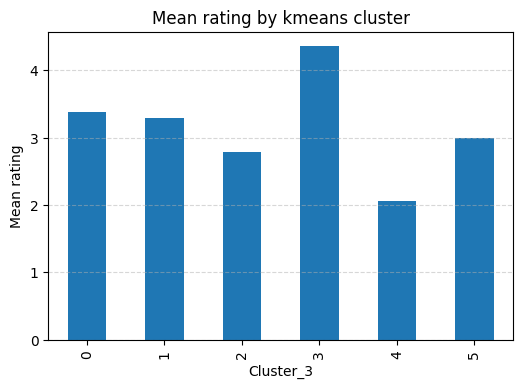

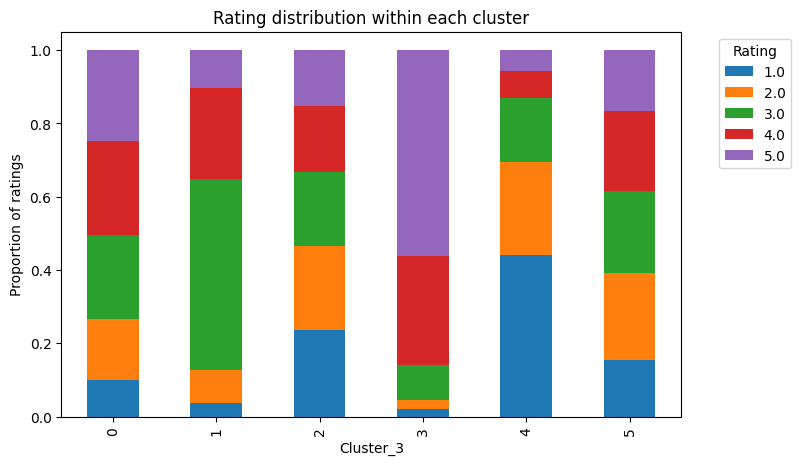

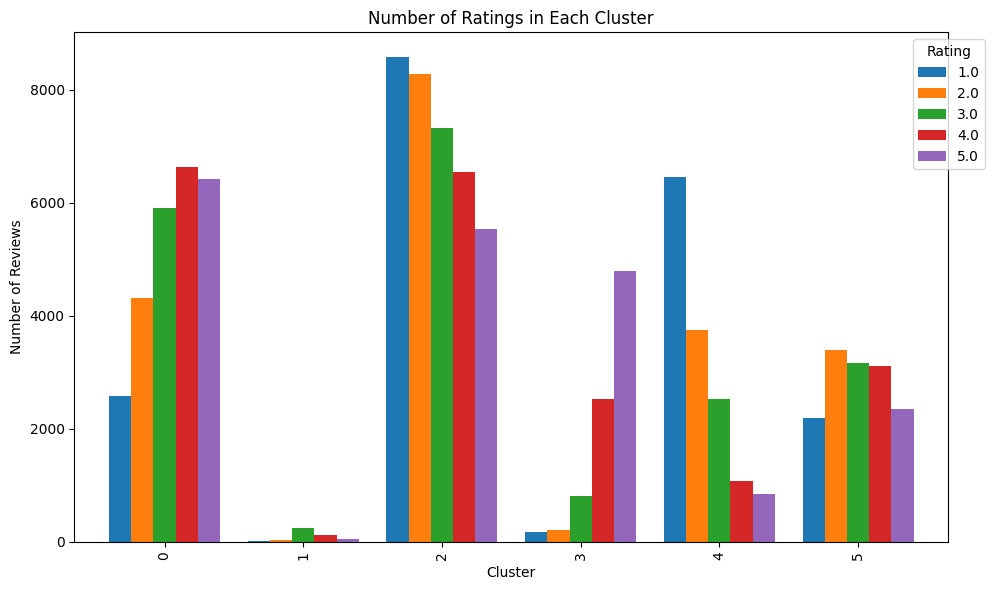

In [18]:
cluster_3_means = balanced_df.groupby("cluster_3")["rating"].mean()

plt.figure(figsize=(6,4))
cluster_3_means.plot(kind="bar")
plt.ylabel("Mean rating")
plt.xlabel("Cluster_3")
plt.title("Mean rating by kmeans cluster")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

rating_dist_3 = pd.crosstab(balanced_df["cluster_3"], balanced_df["rating"], normalize="index")

rating_dist_3.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Proportion of ratings")
plt.xlabel("Cluster_3")
plt.title("Rating distribution within each cluster")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

count_table_3 = pd.crosstab(balanced_df["cluster_3"], balanced_df["rating"])

count_table_3.plot(kind="bar", figsize=(10,6), width=0.8)

plt.title("Number of Ratings in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

* cluster 1: more NEUTRAL (3.0) reviews
* cluster 3: more POSITIVE (5.0) reviews
* cluster 4: more NEGATIVE (1.0) reviews

In [19]:
# TFIDF to find keywords

# Fit vectorizer 
tfidf_3 = TfidfVectorizer(max_features=5000, min_df=5, stop_words= "english") # review x word matrix where entries are tfidf (importance) scores
X = tfidf_3.fit_transform(texts)
vocab = np.array(tfidf_3.get_feature_names_out())

# Find top n keywords per cluster
top_n = 20
for cluster in sorted(balanced_df["cluster_3"].unique()):
    mask = balanced_df["cluster_3"] == cluster # vector identifying which reviews are in cluster
    X_cluster = X[mask.to_numpy()] # only include reviews in cluster
    
    # Calculate average tfidf score per word in cluster and sort descending
    mean_tfidf_3 = X_cluster.mean(axis=0)
    mean_tfidf_3 = np.asarray(mean_tfidf_3).ravel()
    top_idx = mean_tfidf_3.argsort()[::-1][:top_n]
    top_words = vocab[top_idx]

    # Display
    print(f"\nCluster {cluster} top words:")
    print(", ".join(top_words))


Cluster 0 top words:
case, great, like, good, use, ipad, works, fit, just, camera, cover, product, nice, easy, little, price, does, love, tablet, really

Cluster 1 top words:
ok, okay, just, fine, crap, works, alright, product, price, great, said, does, husband, kinda, kick, sucks, like, idk, spectacular, child

Cluster 2 top words:
work, use, cable, just, works, tv, great, time, battery, like, usb, good, does, camera, power, don, phone, device, screen, charge

Cluster 3 top words:
great, good, works, product, love, price, quality, perfect, nice, expected, easy, excellent, worked, described, advertised, like, value, work, job, far

Cluster 4 top words:
work, didn, did, returned, months, broke, working, worked, return, product, money, stopped, just, buy, item, bought, don, time, waste, use

Cluster 5 top words:
sound, headphones, quality, ear, good, great, speaker, speakers, music, ears, use, like, volume, just, noise, bass, bluetooth, earbuds, better, work



* cluster 1: decent products; nothing great or bad about them 
* cluster 3: strong positive adjectives to describe products
* cluster 4: faulty / broken products that are not working, customers considering to review themm

**Prisca's work: ___________________________________________**

Since cluster 0 and cluster 1 have almost equal amount of ratings per cluster, I wanted to analyze what the difference of cluster 0 and 1 could possibly be: 

edit: the below works mainly are EDA intepretatons of the clusters we've made

In [20]:
#kept the rows in initial k-means (3 clusters) that were labeled as negative + neutral
cluster_01 = balanced_df[(balanced_df["cluster"] == 0) | (balanced_df["cluster"] == 1)] 

In [21]:
cluster_01.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,cleaned_text,cluster,cluster_2,cluster_3
0,1.0,Looks like something you get at the dollar store,Cheap looking. Looks like something you get a...,[],B01AG1GYLG,B09Y52BZC8,AFWIMAWDZVZIZPI4RT22S4N44OKQ,1492230370000,0,True,cheap looking looks like something you get at ...,1,0,0
1,1.0,didn't really work,"I would look for another product, to provide y...",[],B014YN7LVE,B014YN7LVE,AF2II3AEAIAWPYLIL3EGSLGZXHRQ,1633074481836,0,True,i would look for another product to provide yo...,1,4,2
3,1.0,"Good idea, defective screen...",Do not buy this. After a couple of months of u...,[],B00N7MFZGM,B00N7MFZGM,AHE2BITVBXIVESDN3A6YRHYT7R6Q,1463584075000,0,False,do not buy this after a couple of months of us...,0,4,2
4,1.0,Broke out of the box,I'm a big TomTom fan and recommend them to man...,[],B003B3P2CY,B003B3P2CY,AHWRXLKSLGKDWKHTMUI2LHXJLOWA,1294088291000,2,True,i m a big tomtom fan and recommend them to man...,0,4,2
5,1.0,One Star,didnt work,[],B01C43FYLK,B01C43FYLK,AFYDP4SD7JT2AJ2I2G7KOEOWEOIA,1512765897519,0,True,didnt work,0,1,4


In [22]:
#reviewing the length of product reviews 
cluster_01["text_length"] = cluster_01["cleaned_text"].str.split().apply(len)

/var/folders/zl/rkhnr4jj3m562vr5p3lz0jb40000gn/T/ipykernel_96848/2531895783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_01["text_length"] = cluster_01["cleaned_text"].str.split().apply(len)


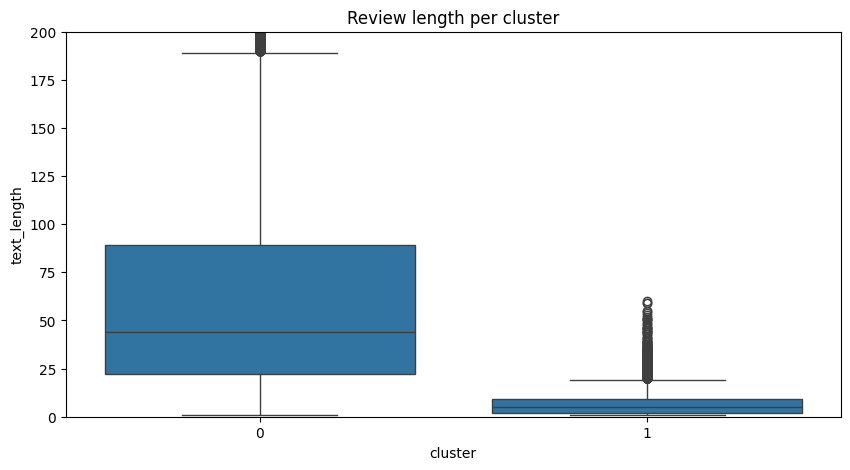

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(data=cluster_01, x="cluster", y="text_length")
plt.ylim(0,200)
plt.title("Review length per cluster")
plt.show()

Cluster 0 labeled as negative reviews have a longer length when compared to cluster 1, which is labeled as neutral reviews that have a strikingly shorter review

In [24]:
for c in [0,1]:
    print(f"\n=== Cluster {c} example reviews ===")
    print(cluster_01[cluster_01["cluster"] == c]["text"].sample(5, random_state=42).values)


=== Cluster 0 example reviews ===
['Does not fit tablet it is too big'
 'Very irrutated that the pen was straight dry'
 "We live just about 25 miles from the city and we can't hold a signal with this in the second story of our house. Just doesn't work for us. I gave it two star since it dose seem to be a well made unit and maybe with an amp it would work?"
 "Review for GTX 1060 Mini ITX OC 3GB. Just installed in a PC which has an AMD FX-8320e CPU and 8 GB RAM. I've run the 90 second benchmark included in Deus EX using default settings of high to a 1080p TV. Average frame rates 51. High 60. Low 34. Upgrading from a Radeon R7 250 is a huge performance boost. The fan stays off until GPU temperature rises. It's quiet when running."
 'These are super small and flimsy. I wouldn’t buy again.']

=== Cluster 1 example reviews ===
['It was DOA.' 'bad quality' 'A nice buy, handy, arrived on time.'
 'Bought as a gift' 'Was easy to install']


In [25]:
cluster0_texts = cluster_01[cluster_01["cluster"] == 0]["cleaned_text"]
cluster1_texts = cluster_01[cluster_01["cluster"] == 1]["cleaned_text"]

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words= 'english')
X0 = vectorizer.fit_transform(cluster0_texts)
X1 = vectorizer.fit_transform(cluster1_texts)

feature_names = vectorizer.get_feature_names_out()

def top_terms(tfidf_matrix, feature_names, top_n=20):
    avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = avg_tfidf.argsort()[::-1][:top_n]
    return [(feature_names[i], avg_tfidf[i]) for i in top_indices]

print("Cluster 0 top words:", top_terms(X0, feature_names))
print("Cluster 1 top words:", top_terms(X1, feature_names))

Cluster 0 top words: [('works great', np.float64(0.023579969736662473)), ('value price', np.float64(0.02143019921737014)), ('item worthy', np.float64(0.01971981368669414)), ('great needs', np.float64(0.019109946505048714)), ('lightweight', np.float64(0.01893408955703056)), ('great gift', np.float64(0.018326370205515082)), ('works price', np.float64(0.01765695268725773)), ('colors', np.float64(0.016779223258725353)), ('present', np.float64(0.015242632679739247)), ('christmas', np.float64(0.014872563485727814)), ('expensive', np.float64(0.014787468059239951)), ('things work', np.float64(0.014050840478437871)), ('fairly', np.float64(0.01371004732857057)), ('everyday', np.float64(0.013538960728779909)), ('cap', np.float64(0.012968878562724497)), ('exactly expected', np.float64(0.012594212872054372)), ('product exactly', np.float64(0.012033294053543246)), ('really love', np.float64(0.012030575981342873)), ('extremely', np.float64(0.01196650344944898)), ('fine good', np.float64(0.01123820863

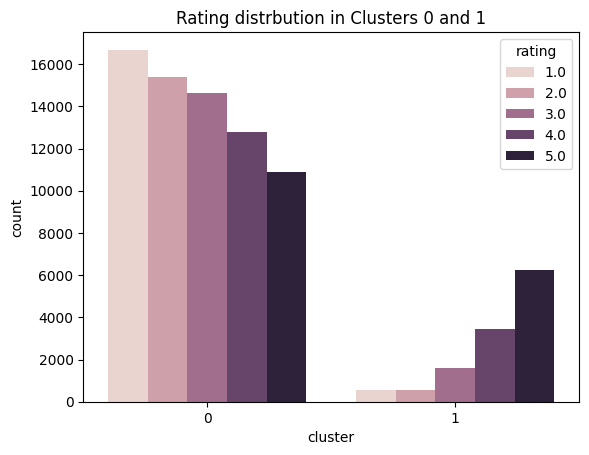

In [26]:
sns.countplot(data = cluster_01, x = "cluster", hue = "rating")
plt.title("Rating distrbution in Clusters 0 and 1")
plt.show()

In [27]:
labels = balanced_df["cluster"].values

centroids = {}

cluster_id = [0,1]
for c in cluster_id:
    vectors = embeddings[labels == c]
    centroids[c] = vectors.mean(axis = 0)

for c in cluster_id:
    print(f"Cluster {c} centroid shape:", centroids[c].shape)

Cluster 0 centroid shape: (384,)
Cluster 1 centroid shape: (384,)


In [28]:
def closest_reviews(cluster_id, top_n=5):
    mask = labels == cluster_id
    vectors = embeddings[mask]
    
    # distances from each review to the cluster centroid
    dists = np.linalg.norm(vectors - centroids[cluster_id], axis=1)
    
    # sort by distance (smallest first)
    idx_sorted = np.argsort(dists)[:top_n]
    
    # grab the corresponding rows from balanced_df
    cluster_df = balanced_df[mask]
    return cluster_df.iloc[idx_sorted][["rating", "text", "cleaned_text"]]

for c in cluster_id:
    print(f"\n=== Cluster {c}: most representative reviews ===\n")
    display(closest_reviews(c, top_n=5))


=== Cluster 0: most representative reviews ===



,rating,text,cleaned_text
20202,2.0,"UPDATE... On no, fail! It worked great at firs...",update on no fail it worked great at first but...
71762,4.0,This came well packaged and the stand is all m...,this came well packaged and the stand is all m...
23725,2.0,I purchased this model in late 2015 and while ...,i purchased this model in late 2015 and while ...
27479,2.0,We have had this for a month and are experienc...,we have had this for a month and are experienc...
43266,3.0,I searched Amazon for something like this to h...,i searched amazon for something like this to h...



=== Cluster 1: most representative reviews ===



,rating,text,cleaned_text
99746,5.0,The products work great and for the money a de...,the products work great and for the money a de...
60146,4.0,"Just got this today, ships fast and for the pr...",just got this today ships fast and for the pri...
60105,4.0,I mostly got this because it is very aesthetic...,i mostly got this because it is very aesthetic...
68356,4.0,It is perfectly adequate. It's not ugly. It's ...,it is perfectly adequate it s not ugly it s no...
80394,5.0,Great deal. It seems less than 50' but it work...,great deal it seems less than 50 but it works ...


In [29]:
cluster_01 = balanced_df[balanced_df["cluster"].isin(cluster_id)].copy()

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=5,
    stop_words= 'english'
)

X = vectorizer.fit_transform(cluster_01["cleaned_text"])
feature_names = vectorizer.get_feature_names_out()

def top_terms_for_cluster(c, top_n=15):
    mask = cluster_01["cluster"].values == c
    X_c = X[mask]
    mean_scores = np.asarray(X_c.mean(axis=0)).ravel()
    idx = mean_scores.argsort()[::-1][:top_n]
    return [feature_names[i] for i in idx]

print("Cluster 0 top terms:\n", top_terms_for_cluster(0))
print("\nCluster 1 top terms:\n", top_terms_for_cluster(1))

Cluster 0 top terms:
 ['work', 'use', 'just', 'like', 'great', 'good', 'works', 'case', 'camera', 'does', 'product', 'time', 'don', 'did', 'bought']

Cluster 1 top terms:
 ['good', 'great', 'works', 'ok', 'love', 'product', 'works great', 'nice', 'price', 'quality', 'perfect', 'easy', 'expected', 'great product', 'like']


In [30]:
# Using raw text reviews

# Create vector embeddings from cleaned text
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

raw_texts = balanced_df["text"].tolist()
raw_embeddings = model.encode(raw_texts, batch_size=64, device=device, show_progress_bar=True)

Batches:   0%|          | 0/1562 [00:00<?, ?it/s]

In [31]:
k = 3

# Run k means and store labels
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
raw_kmeans_labels = kmeans.fit_predict(raw_embeddings)
balanced_df["raw cluster"] = raw_kmeans_labels
balanced_df[["rating", "cleaned_text", "raw cluster"]].head(10)

,rating,cleaned_text,raw cluster
0,1.0,cheap looking looks like something you get at ...,1
1,1.0,i would look for another product to provide yo...,1
2,1.0,lids are very loose,2
3,1.0,do not buy this after a couple of months of us...,0
4,1.0,i m a big tomtom fan and recommend them to man...,0
5,1.0,didnt work,0
6,1.0,this unit sucks had to return it cause you can...,0
7,1.0,it has one function and doesn t perform that f...,0
8,1.0,garbage has static feedback,0
9,1.0,these panasonic earbuds work fairly well but d...,2


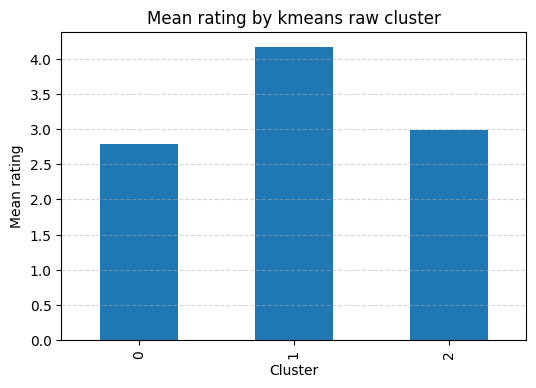

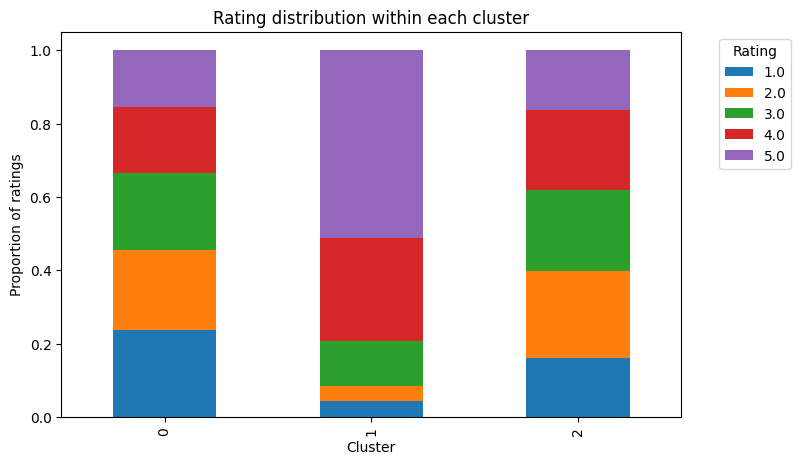

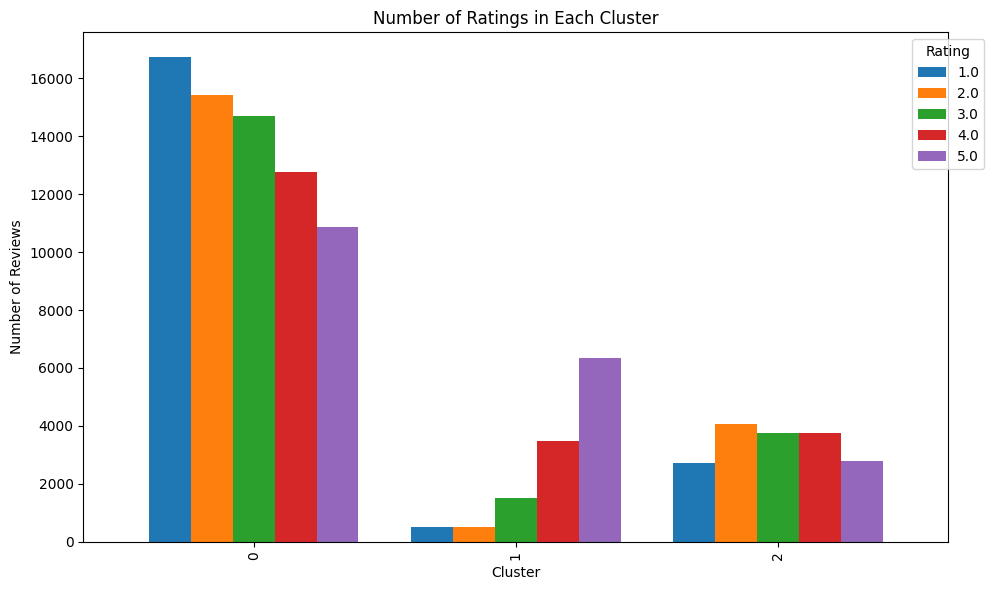

In [32]:
# Visualize k means - weihao's version

cluster_means = balanced_df.groupby("raw cluster")["rating"].mean()

plt.figure(figsize=(6,4))
cluster_means.plot(kind="bar")
plt.ylabel("Mean rating")
plt.xlabel("Cluster")
plt.title("Mean rating by kmeans raw cluster")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


rating_dist = pd.crosstab(balanced_df["raw cluster"], balanced_df["rating"], normalize="index")

rating_dist.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Proportion of ratings")
plt.xlabel("Cluster")
plt.title("Rating distribution within each cluster")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

count_table_raw = pd.crosstab(balanced_df["raw cluster"], balanced_df["rating"])

count_table_raw.plot(kind="bar", figsize=(10,6), width=0.8)

plt.title("Number of Ratings in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [33]:
# TFIDF to find keywords

# Fit vectorizer 
tfidf = TfidfVectorizer(max_features=5000, min_df=5, stop_words = 'english') # review x word matrix where entries are tfidf (importance) scores
X = tfidf.fit_transform(raw_texts)
vocab = np.array(tfidf.get_feature_names_out())

# Find top n keywords per cluster
top_n = 10
for cluster in sorted(balanced_df["raw cluster"].unique()):
    mask = balanced_df["raw cluster"] == cluster # vector identifying which reviews are in cluster
    X_cluster = X[mask.to_numpy()] # only include reviews in cluster
    
    # Calculate average tfidf score per word in cluster and sort descending
    mean_tfidf = X_cluster.mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    top_words = vocab[top_idx]

    # Display
    print(f"\nCluster {cluster} top words:")
    print(", ".join(top_words))


Cluster 0 top words:
br, work, use, just, like, great, works, case, good, does

Cluster 1 top words:
great, good, works, product, love, ok, price, quality, nice, perfect

Cluster 2 top words:
sound, br, headphones, good, quality, ear, great, speaker, speakers, music


In [34]:
# Add our custom reviews to test on our best k-means model (6 clusters)
custom_reviews = [
    "The sound quality is amazing, but the device overheats constantly and shuts off.",     # mixed sentiment
    "Runs fast, but takes too much power.",
    "Wow, what a great product… if you enjoy things that never work.",                      # sarcasm
    "Good job making a worse product!",
    "Includes charger and cable. Everything matches the listing.",                          # hard neutral
    "The durability is awfully good for something this cheap.",                             # fake negative
    "It's scary how well this fits my computer.",
    "The battery life is amazingly bad. I can’t believe how fast it dies.",                 # fake positive
    "This looked pretty ugly compared to the photos."
]

# collapses process to one function
def predict_cluster(review, model, kmeans):
    cleaned = clean_text(review)
    embedding = model.encode([cleaned])
    cluster = kmeans.predict(embedding)[0]
    return cluster

# predict for every custom review
for r in custom_reviews:
    c = predict_cluster(r, model, kmeans_3)
    print(f"Cluster {c}: {r}")


Cluster 5: The sound quality is amazing, but the device overheats constantly and shuts off.
Cluster 2: Runs fast, but takes too much power.
Cluster 3: Wow, what a great product… if you enjoy things that never work.
Cluster 3: Good job making a worse product!
Cluster 2: Includes charger and cable. Everything matches the listing.
Cluster 0: The durability is awfully good for something this cheap.
Cluster 0: It's scary how well this fits my computer.
Cluster 2: The battery life is amazingly bad. I can’t believe how fast it dies.
Cluster 0: This looked pretty ugly compared to the photos.
